In [67]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: white;
}
</style>

In [1]:
# </path/to>/build/bin/hipace <input>

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch

import sys
sys.path.append('/Users/max/HiPACE/src/hipace/tools/')
import read_insitu_diagnostics as diag

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
# print(plt.rcParams.keys())
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.style.use('classic')

from scipy.integrate import quad
import scipy.special as special

In [2]:
def GeV2P(pG: float) -> float:
    """
    Calculates momentum value for HiPACE++ input file from GeV/c value
    
    Parameters
    ----------
    pG : float
        momentum in GeV/c
    
    Returns
    -------
    p : float
        momentum in HiPACE++ input file units
    """
    pG *= 1e9 * constants.e / constants.c # 1 [GeV/c] = eV / (m/s) = kg m / s

    return pG / (constants.m_e * constants.c)

def skinDepth(ne = 1e17):
    '''
    Calculates plasma skin depth based off plasma electron density

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3).  Defaults to 1e17 cm^-3
    
    Returns
    -------
    kp_inv : float
        plasma skin depth in m
    '''

    # if unit == 'SI':
    wp = 1e-3 * np.sqrt((ne * constants.e**2) / (constants.epsilon_0 * constants.m_e)) # SI
    # elif unit == 'CGS':
        # wp = np.sqrt((4 * constants.pi * ne * constants.e**2) / (constants.m_e)) # CGS
    
    kp_inv = 1e-6 * constants.c / wp # m
    
    return kp_inv

def E0(n0: float) -> float:
    kp = skinDepth(n0) ** -1 # m^-1
    return constants.m_e * constants.c**2 * kp / constants.e # V/m

def gaussian(z, dz, mu = 0):
    return 1 / (dz * np.sqrt(2 * np.pi)) * np.exp(-(z - mu)**2 / (2 * dz**2))

def gaussianR(r, dr, mu = 0):
    return 1 / (dr**2 * 2 * np.pi) * np.exp(-(r - mu)**2 / (2 * dr**2))

def gaussianRderiv(r, dr, mu = 0):
    return -(r - mu) / dr**2 * gaussianR(r, dr, mu)

def leftright(r0: float, r: np.ndarray) -> np.ndarray:
    left = np.heaviside(r0 - r, 0.5)
    right = np.heaviside(r - r0, 0.5)

    return left, right

def g0(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    return 4 * np.pi * ((special.i0(kp * r) * special.k0(kp * r0) * left + special.i0(kp * r0) * special.k0(kp * r) * right))

def g1(r0: float, r: np.ndarray, n0: float) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    sgn = np.sign(r)
    r0 = abs(r0)
    r = abs(r)

    left, right = leftright(r0, r)

    return 4 * np.pi * sgn * ((special.i1(kp * r) * special.k1(kp * r0) * left + special.i1(kp * r0) * special.k1(kp * r) * right))

def longitudinal(xi: np.ndarray, dz: float, Nb: float, n0: float, sin: bool) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1

    z = Nb * gaussian(xi, dz) # m^-1
    
    if sin:
        W_z = -kp * np.sin(kp * xi) # m^-1
    else:
        W_z = -kp * np.cos(kp * xi) # m^-1
        
    
    Xi = 1e-6 * np.convolve(z, W_z)[:len(xi)] # m^-1 (assuming integration measure is in microns)

    return Xi

def makefield(xi, r):
    n, m = len(xi), len(r)

    F = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            F[i, j] = r[i] * xi[j]

    return F

def n1(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float) -> np.ndarray:
    '''
    Parameters
    ----------
    n0 : float
        plasma electron density (in cm^-3)
    '''

    R = gaussianR(r, dr) # m^-2

    Xi = longitudinal(xi, dz, Nb, n0, sin = True) # m^-1

    n_1 = makefield(Xi, R) # m^-3

    return Xi, R, n_1 / (1e6 * n0)

def Ez(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss = True, eV = False) -> np.ndarray:
    '''
    Parameters
    ----------
    eV : bool
        whether to output Ez in GeV/m (True) or V/m (False).  Defaults to False.
    '''
    kp = skinDepth(n0) ** -1 # m^-1

    Xi = longitudinal(xi, dz, Nb, n0, sin = False) # m^-1

    if gauss:
        r_int = kp * constants.e * np.array([quad(lambda R: gaussianR(R, dr) * g0(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # C m^-1
    else:
        r_int = kp * constants.e * np.array([quad(lambda R: 1 / (2 * np.pi * dr**2) * g0(r0, R, n0) * R, 0, dr)[0] for r0 in r]) # C m^-1

    E_z = makefield(Xi, r_int) # C m^-2

    C = 1 / (4 * np.pi * constants.epsilon_0) # m/F = C^-1 V m

    E_0 = E0(n0) # V/m
    # print(E0)

    if eV:
        return Xi, r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_z / E_0

def EzR_analytic(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, eV = False) -> np.ndarray:
    r = abs(r) # m
    
    kp = skinDepth(n0) ** -1 # m^-1

    left, right = leftright(dr, r)

    Xi = longitudinal(xi, dz, Nb, n0, sin = False) # m^-1

    # C = constants.e * kp / (2 * np.pi * dr**2 * constants.epsilon_0) # C m^-1 * m^-2 * m/F = m^-2 * C * V / C = V m^-2
    C = constants.e / (2 * np.pi * dr**2 * constants.epsilon_0) # C * m^-2 * m/F = m^-1 * C * V / C = V/m

    r_int = left * r * (special.i1(kp * r) * special.k0(kp * r) + special.i0(kp * r) * (special.k1(kp * r) - (dr / r) * special.k1(kp * dr))) + right * dr * special.i1(kp * dr) * special.k0(kp * r) # m

    E_z = makefield(Xi, r_int) # unitless

    E_0 = E0(n0) # V/m

    if eV:
        return r_int, constants.e * C * E_z * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return r_int, C * E_z / E_0

def Er(r: np.ndarray, dr: float, xi: np.ndarray, dz: float, Nb: float, n0: float, gauss = True, eV = False) -> np.ndarray:
    kp = skinDepth(n0) ** -1 # m^-1
    
    C = constants.e / (2 * np.pi * dr**2 * constants.epsilon_0) # C * m^-2 * m/F = m^-1 * C * V / C = V/m
    E_0 = E0(n0) # V/m

    sgn = np.sign(r)
    r = abs(r) # m

    Xi = longitudinal(xi, dz, Nb, n0, sin = True) # m^-1

    left, right = leftright(dr, r)

    if gauss:
        r_int = sgn * 2 * np.pi * dr**2 * np.array([quad(lambda R: gaussianRderiv(R, dr) * g1(r0, R, n0) * R, 0, 1e-2)[0] for r0 in r]) # m^2 * m^-1 = m
    else:
        r_int = -4 * np.pi * sgn * (left * special.k1(kp * dr) * special.i1(kp * r) + right * special.i1(kp * dr) * special.k1(kp * r)) # m

    E_r = makefield(Xi, r_int) # unitless

    if eV:
        return Xi, r_int, constants.e * C * E_r * 6.242e9 # 6.242*10^9 * e * V / m = GeV / m
    else:
        return Xi, r_int, C * E_r / E_0


In [3]:
# DOMAIN
res = 1e-6 # m
rmin, rmax, ximin, ximax = -150e-6, 150e-6, -100e-6, 350e-6 # m
r, xi = np.arange(rmin, rmax, res), np.arange(ximin, ximax, res)

# print(r.shape, xi.shape)

# BEAM PARAMETERS
u = 'SI'
Nb = 4e8
n0 = 8e16   # cm^-3
dr = 20e-6  # m
dz = 15e-6  # m

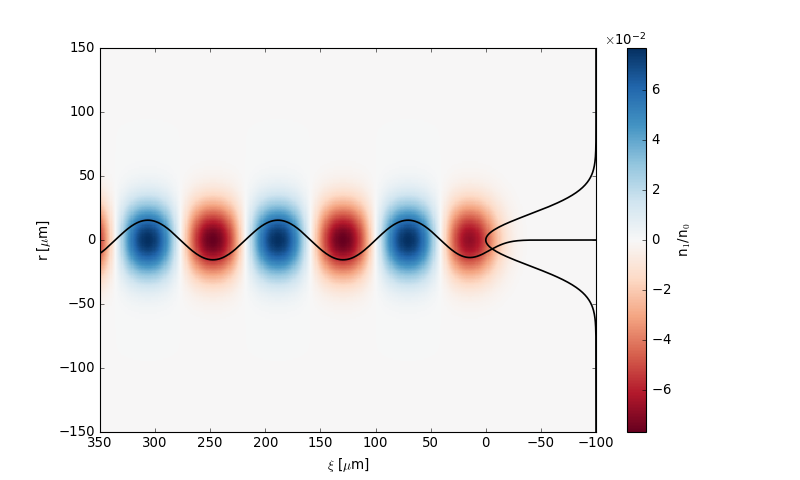

In [5]:
Xi_1, R_1, n_1 = n1(r, dr, xi, dz, Nb, n0)

plt.close()
plt.figure(4, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * xi, 1e6 * r, n_1, cmap = 'RdBu') #, vmin = -1e-3, vmax = 1e-3) # why did we need to multiply by 1e-5?  Where did it come from?
plt.xlim(1e6 * ximax, 1e6 * ximin)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

plt.plot(1e6 * xi, 1e-12 * Xi_1, 'k', linewidth = 1.5)
plt.plot(1e2 * max(R_1)**-1 * R_1 - 100, 1e6 * r, 'k', linewidth = 1.5)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'n$_1$/n$_0$')

plt.show()

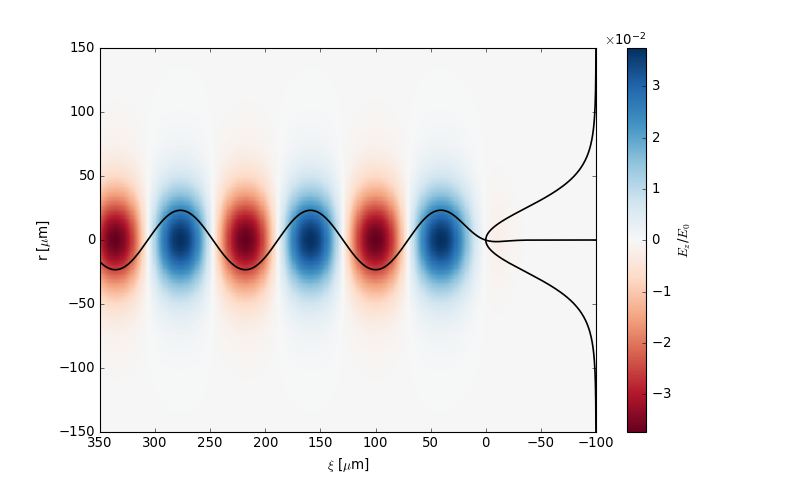

In [67]:
analytical = False
coord = ''
GeV = False

Xi, R, E_z = Ez(r, dr, xi, dz, Nb, n0, gauss = True, eV = GeV)
zR, E_zR = EzR_analytic(r, dr, xi, dz, Nb, n0, eV = GeV)

# print((E_zR / E_z)[0,0], 1e6 * skinDepth(n0) ** -1)

plt.close()
plt.figure(5, figsize = (10, 6), facecolor = 'w')

if coord == 'kp':
    kp = skinDepth(n0) ** -1 # m^-1

    if analytical:
        img = plt.pcolormesh(kp * xi, kp * r, E_zR, cmap = 'RdBu') # , vmin = -5e-3, vmax = 5e-3)
        plt.plot(100e-6 * kp * (max(R)**-1 * R - 1), kp * r, 'k', linewidth = 1.5)
    else:
        img = plt.pcolormesh(kp * xi, kp * r, E_z, cmap = 'RdBu') # , vmin = -5e-3, vmax = 5e-3)
        plt.plot(100e-6 * kp * (max(R)**-1 * R - 1), kp * r, 'k', linewidth = 1.5)


    plt.plot(kp * xi, 5e-14 * Xi, 'k', linewidth = 1.5)

    plt.xlim(kp * ximax, kp * ximin)
    # plt.ylim(-3.5, 3.5)
    plt.ylim(kp * rmin, kp * rmax)
    plt.xlabel(r'$k_p\xi$')
    plt.ylabel(r'$k_p r$')
else:
    if analytical:
        img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_zR, cmap = 'RdBu') # , vmin = -1e4, vmax = 1e4)
        plt.plot(1e2 * max(zR)**-1 * zR - 100, 1e6 * r, 'k', linewidth = 1.5)
    else:
        img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_z, cmap = 'RdBu')
        plt.plot(1e2 * max(R)**-1 * R - 100, 1e6 * r, 'k', linewidth = 1.5)

    plt.plot(1e6 * xi, 1.5e-12 * Xi, 'k', linewidth = 1.5)

    plt.xlim(1e6 * ximax, 1e6 * ximin)
    plt.ylim(1e6 * rmin, 1e6 * rmax)
    plt.xlabel(r'$\xi$ [$\mu$m]')
    plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)

if GeV:
    cb.set_label(r'$E_z$ [GeV$\cdot$m$^{-1}$]')
else:
    cb.set_label(r'$E_z$/$E_0$')

plt.show()

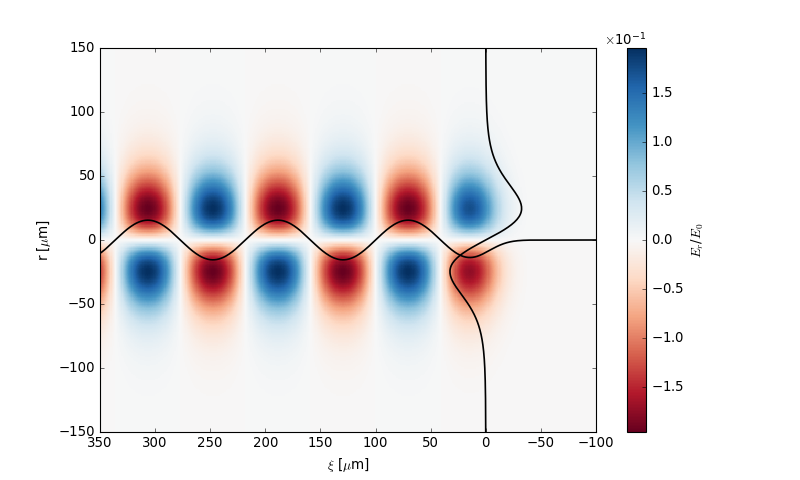

In [7]:
GeV = False
Xi, R, E_r = Er(r, dr, xi, dz, Nb, n0, gauss = True, eV = GeV)

plt.close()
plt.figure(6, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * xi, 1e6 * r, E_r, cmap = 'RdBu') #, vmin = -1e-3, vmax = 1e-3) # why did we need to multiply by 1e-5?  Where did it come from?
plt.xlim(1e6 * ximax, 1e6 * ximin)
plt.ylim(1e6 * rmin, 1e6 * rmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

plt.plot(1e6 * xi, 1e-12 * Xi, 'k', linewidth = 1.5)
plt.plot(.325e2 * max(R)**-1 * R, 1e6 * r, 'k', linewidth = 1.5)

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)

if GeV:
    cb.set_label(r'$E_r$ [GeV$\cdot$m$^{-1}$]')
else:
    cb.set_label(r'$E_r$/$E_0$')

plt.show()

In [8]:
kp = skinDepth(n0) ** -1 # µm^-1

print(kp * dr)

1.064500371190005


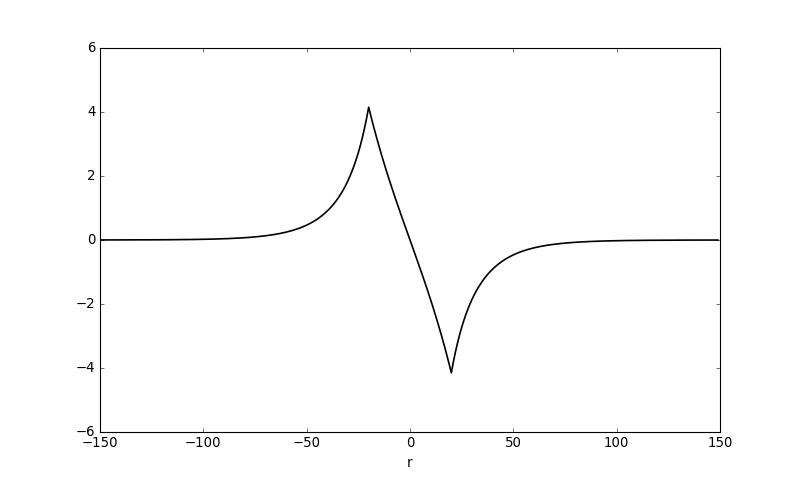

In [9]:
# zR, E_zR = EzR_analytic(r, dr, xi, dz, Nb, n0)
# _, R, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = False)
_, R, _ = Er(r, dr, xi, dz, Nb, n0, gauss = False)

# zR = np.nan_to_num(zR)

plt.close()
plt.figure(7, figsize = (10, 6), facecolor = 'w')

# plt.plot(1e6 * r, g1(dr, r, n0), 'r--', linewidth = 1.5)
plt.plot(1e6 * r, R, 'k', linewidth = 1.5)
# plt.plot(1e6 * r, max(R)**-1 * R, 'r', linewidth = 1., label = 'Numerical')
# plt.plot( 1e6 * r, max(zR)**-1 * zR, 'k--', linewidth = 1.75, label = 'Analytic')
# plt.plot( 1e6 * r, leftright(50e-6, r)[1], 'k:', linewidth = 1.5)
# plt.plot( 1e6 * r, (R * zR), 'b', linewidth = 1.5)
# plt.plot( 1e6 * r, g(r0, r, n0) * r0 * 1e6, linewidth = 1.5)
# plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel('r')
plt.show()

# print(zR)

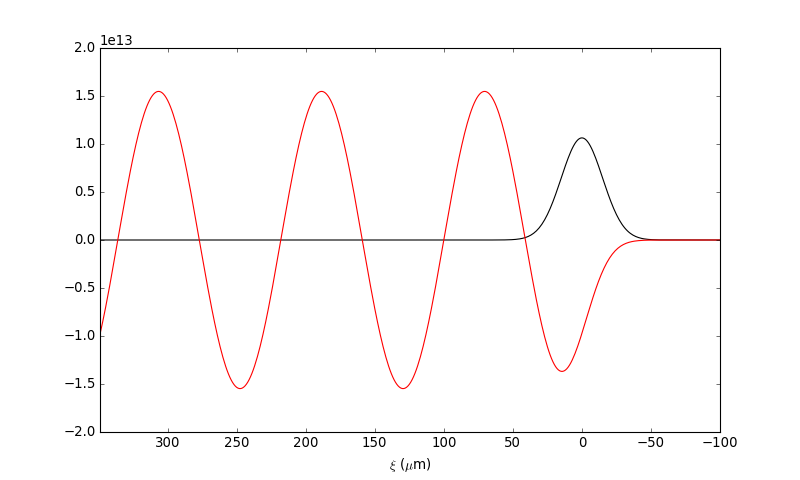

In [10]:
kp = skinDepth(n0) ** -1 # µm^-1

Z = Nb * gaussian(xi, dz)
W_z = -kp * np.sin(kp * xi)

plt.close()
plt.figure(8, figsize = (10, 6), facecolor = 'w')
plt.plot(1e6 * xi, Z, 'k')
plt.plot(1e6 * xi, 1e-6 * np.convolve(Z, W_z)[:len(xi)], 'r')
plt.xlabel(r'$\xi$ ($\mu$m)')
plt.xlim(1e6 * xi[-1], 1e6 * xi[0])
plt.show()

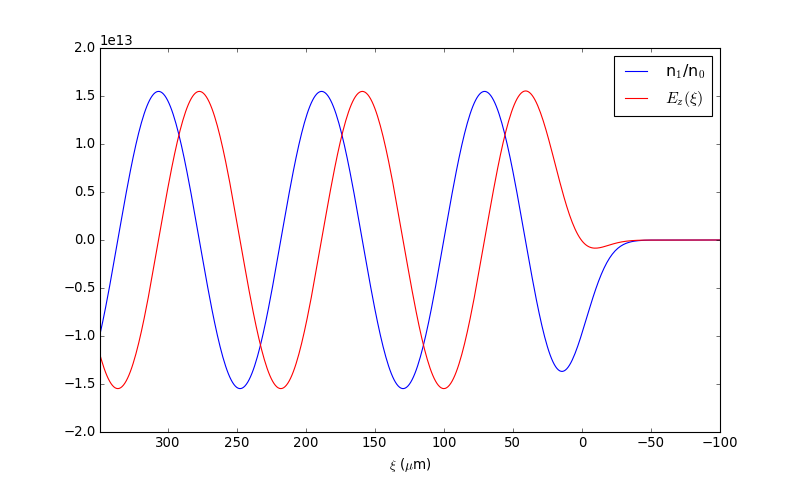

In [11]:
# Xi = Ez(r, dr, xi, dz, Nb, n0)[0]

# kp = skinDepth(n0) ** -1 # µm^-1

# Z = Nb * gaussian(xi, dz)
# W_z = kp * np.sin(1e6 * kp * xi)
# W_Ez = -kp * np.cos(1e6 * kp * xi)

plt.close()
plt.figure(9, figsize = (10, 6), facecolor = 'w')
plt.plot(1e6 * xi, longitudinal(xi, dz, Nb, n0, True), 'b')
plt.plot(1e6 * xi, longitudinal(xi, dz, Nb, n0, False), 'r')
# plt.plot(1e6 * xi, np.convolve(Z, W_z)[:len(xi)], 'b')
# plt.plot(1e6 * xi, np.convolve(Z, W_Ez)[:len(xi)], 'r')
# plt.plot(1e6 * xi, Xi, 'r')
plt.xlabel(r'$\xi$ ($\mu$m)')
plt.xlim(1e6 * xi[-1], 1e6 * xi[0])
plt.legend([r'n$_1$/n$_0$', r'$E_z(\xi)$'])
# plt.yticks([])
plt.show()

In [12]:
GeV2P(10)

19569.511835738733

In [4]:
ts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/linearSI/', check_all_files = True)
beamInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/reduced_beam.0000.txt')
plasmaInsitu = diag.read_file('/Users/max/HiPACE/recovery/diags/insitu/linearSI/reduced_plasma.0000.txt')

In [16]:
print("Available beam diagnostics:", beamInsitu.dtype.names)
Emean = diag.energy_mean_eV(beamInsitu, True)
print(f'{Emean[Emean != 0.][0]:.2f} eV')
# ustd = diag.normalized_momentum_std(beamInsitu, 'z')
# print(ustd[ustd != 0])
# print(beamInsitu['[uz]'][0][beamInsitu['[uz]'][0] != 0.].shape)

Available beam diagnostics: ('time', 'step', 'n_slices', 'charge', 'mass', 'z_lo', 'z_hi', 'normalized_density_factor', 'is_normalized_units', '[x]', '[x^2]', '[y]', '[y^2]', '[z]', '[z^2]', '[ux]', '[ux^2]', '[uy]', '[uy^2]', '[uz]', '[uz^2]', '[x*ux]', '[y*uy]', '[z*uz]', '[ga]', '[ga^2]', 'sum(w)', 'Np', 'average', 'total')
10000000013.06 eV


In [ ]:
ts.slider(cmap = 'RdBu')

In [5]:
ExmBy, info = ts.get_field('ExmBy', iteration = 0)
EZ, _ = ts.get_field('Ez', iteration = 0)
rho, _ = ts.get_field('rho', iteration = 0)

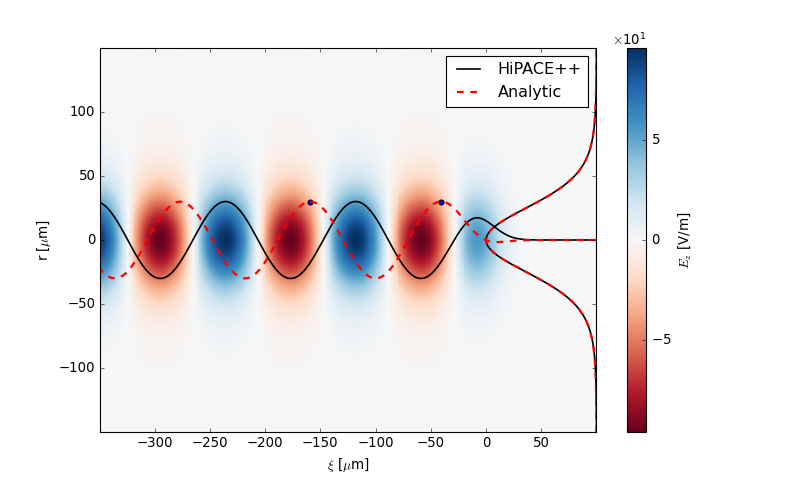

1.0029107537002755


In [9]:
_, R, _ = Ez(r, dr, xi, dz, Nb, n0, gauss = True, eV = False)
z = longitudinal(xi, dz, Nb, n0, False)

m1 = abs(xi) < 50e-6
m2 = np.logical_and(abs(xi) > 100e-6, abs(xi) < 200e-6)
fPeak = np.argmax(abs(z[m1]))
sPeak = np.argmax(z[m2])

plt.close()
plt.figure(10, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, EZ[:, 511//2].T, cmap = 'RdBu')

plt.plot(-1e2 * max(EZ[0, 511//2])**-1 * EZ[0, 511//2] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-1e2 * max(R)**-1 * R + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')

plt.plot(1e6 * info.z, 30 * max(abs(EZ[:, 511//2, 511//2]))**-1 * EZ[:, 511//2, 511//2], 'k', linewidth = 1.5)
plt.plot(-1e6 * xi, 30 * max(abs(z))**-1 * z, 'r--', linewidth = 2.)
plt.scatter(-1e6 * xi[m1][fPeak], 30 * max(abs(z))**-1 * z[m1][fPeak], c = 'b')
plt.scatter(-1e6 * xi[m2][sPeak], 30 * max(abs(z))**-1 * z[m2][sPeak], c = 'b')

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'$E_z$ [V/m]')
plt.legend()
plt.show()

print(z[m1][fPeak] / z[m2][sPeak])

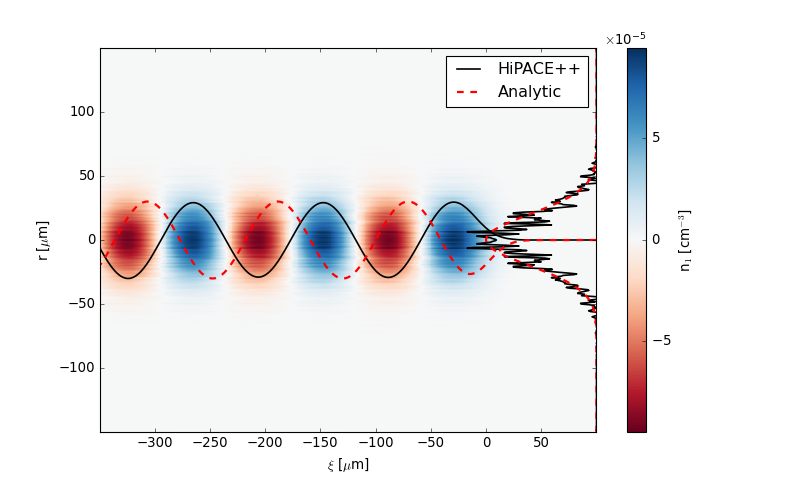

In [21]:
Xi_1, R_1, n_1 = n1(r, dr, xi, dz, Nb, n0)

plt.close()
plt.figure(11, figsize = (10, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, rho[:, 511//2].T, cmap = 'RdBu')

plt.plot(1e1 * max(rho[0, 511//2])**-1 * rho[0, 511//2] + 100, 1e6 * info.x, 'k', linewidth = 1.5, label = 'HiPACE++')
plt.plot(-1e2 * max(R_1)**-1 * R_1 + 100, 1e6 * r, 'r--', linewidth = 2., label = 'Analytic')

plt.plot(1e6 * info.z, 30 * max(abs(rho[:, 511//2, 511//2]))**-1 * rho[:, 511//2, 511//2], 'k', linewidth = 1.5)
plt.plot(-1e6 * xi, 30 * max(abs(Xi_1))**-1 * Xi_1, 'r--', linewidth = 2.)

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'n$_1$ [cm$^{-3}$]')

plt.legend()
plt.show()

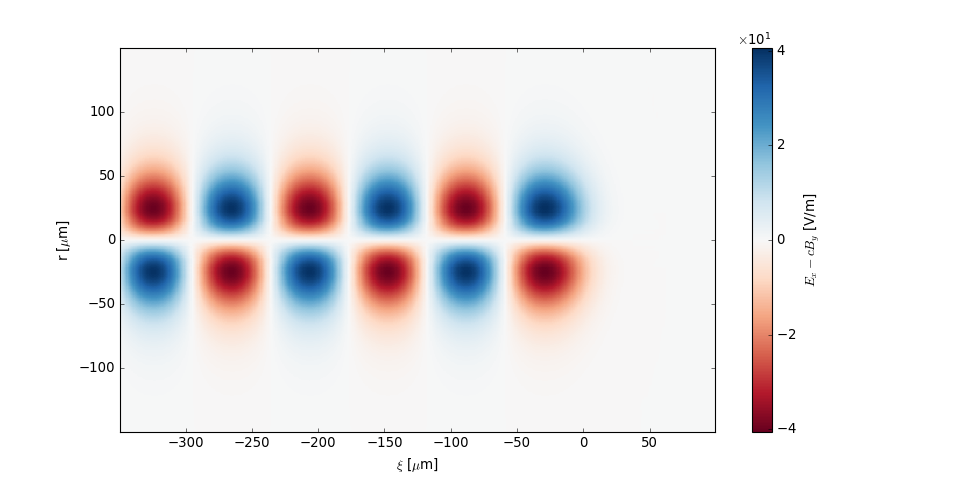

In [7]:
plt.close()
plt.figure(10, figsize = (12, 6), facecolor = 'w')
img = plt.pcolormesh(1e6 * info.z, 1e6 * info.x, ExmBy[:, 511//2].T, cmap = 'RdBu')

# plt.plot(1e2 * max(R)**-1 * R - 100, 1e6 * r, 'k', linewidth = 1.5)
# plt.plot(1e6 * xi, 1.5e-12 * Xi, 'k', linewidth = 1.5)

plt.xlim(1e6 * info.zmin, 1e6 * info.zmax)
plt.ylim(1e6 * info.xmin, 1e6 * info.xmax)
plt.xlabel(r'$\xi$ [$\mu$m]')
plt.ylabel(r'r [$\mu$m]')

cb = plt.colorbar(img)
cb.formatter.set_powerlimits((0, 0))
cb.formatter.set_useMathText(True)
cb.set_label(r'$E_x-cB_y$ [V/m]')
plt.show()